In [41]:
import numpy as np
import matplotlib.pyplot as plt

gravConst = 6.6743 * (10**(-11)) 
mass_sun = 1.989 * (10**30) * gravConst
mass_mercury = 3.285 * (10**23)  * gravConst
mass_venus = 4.867 * (10**24)  * gravConst
mass_earth = 5.972 * (10**24)  * gravConst
mass_mars = 6.39 * (10**23)  * gravConst
mass_moon = 7.342 * (10**22)  * gravConst
distance_mercury = 63.867 * (10**9)
distance_venus = 108.84 * (10**9)
distance_earth = 152.1 * (10**9)
distance_mars = 230.66 * (10**9)
distance_moon = 384.4 * (10**6)
velocity_mercury = 47870
velocity_venus = 35020
velocity_earth = 29300
velocity_mars = 24077
velocity_moon = 1022
offsetspeed = np.array([000, 000, 0])

year = 60 * 60 * 24* 365.2

Defining a general class for a Particle with a mass a position and a velocity.

Where the actual mass is equal to
$$ \frac{self.mass}{G}$$

In [42]:
class Particle:
    def __init__(self, name, mass, coord, velocity, color):
        self.name = name
        self.mass = mass
        self.coord = np.array([coord["x"], coord["y"], coord["z"]])
        self.velocity = np.array([velocity["x"],velocity["y"], velocity["z"]])
        self.color = color
    
    #def accelerate(self, force, dt):
    #    # delta is the velocity the particle is accelerated by in the timestep dt
    #    a = force / (self.mass / gravConst)
    #    delta = a * dt
    #    self.velocity = self.velocity + delta

    def move(self, dt):
        # delta is the distance the particle is moved by in the timestep dt
        delta = self.velocity * dt
        self.coord = self.coord + delta

    def kineticEnergy(self):
        return self.mass / 2 * np.linalg.norm(self.velocity)**2

    def potEnergy(self, otherParticle):
        diff = np.subtract(self.coord, otherParticle.coord)
        radius = np.linalg.norm(diff)
        return - self.mass * otherParticle.mass / radius

    def gravityForcedAcceleration(self, other, dt):
        diff = np.subtract(other.coord, self.coord)
        radius = np.linalg.norm(diff)
        self.velocity = self.velocity + diff * other.mass *dt/ (radius**3)
        other.velocity = other.velocity - diff * self.mass *dt/ (radius**3)
        #return force that applys on self
        #return f_abs * (diff/radius)
    

Create Particles (Solar System)

In [43]:

star = Particle("Sun", mass_sun, {"x": 0, "y": 0, "z": 0 },{"x": 0, "y": 0, "z": 0 }, "#FFEE77" )
#star = Particle("sun", 1000, {"x": 0, "y": 0, "z": 0 },{"x": -0.001, "y": 0, "z": 0 } )
mercury = Particle("Mercury", mass_mercury, {"x": 0, "y": distance_mercury, "z": 0 },{"x": velocity_mercury, "y": 0, "z": 0 }, "#DDCC44" )
venus = Particle("Venus", mass_venus, {"x": 0, "y": distance_venus, "z": 0 },{"x": velocity_venus, "y": 0, "z": 0 }, "#884400" )
earth = Particle("Earth", mass_earth, {"x": 0, "y": distance_earth, "z": 0 },{"x": velocity_earth, "y": 0, "z": 0 }, "#002277" )
mars = Particle("Mars", mass_mars, {"x": 0, "y": distance_mars, "z": 0 },{"x": velocity_mars, "y": 0, "z": 0 }, "#EE1111" )
moon = Particle("Moon", mass_moon, {"x": distance_moon, "y": distance_earth, "z": 0 },{"x": velocity_earth, "y": velocity_moon, "z": 0 }, "#666666")
particles = [star, mercury, venus, earth, mars, moon]
particles = [star, earth]
particleSizes = []
particleColors = []
for pt in particles:
    pt.velocity += offsetspeed
    particleSizes.append((pt.mass**(1/5) / mass_sun**(1/5) * 9))
    particleColors.append(pt.color)

s, c = np.random.random((len(particles), 2)).T
s *= 10
s = particleSizes
#c = particleColors



Verlet Algorithm

In [44]:
def verlet(particles, h, n):
    mmin = np.amin(particles[0].coord)
    mmax = np.amax(particles[0].coord)
    t_axis = np.linspace(0, n*h, num=n)
    energy = np.zeros(n)
    p_axes = []
    for p in particles:
        p_axes.append([np.zeros(n), np.zeros(n), np.zeros(n)])

    for pti in particles:
        for ptj in particles: 
            if ptj == pti:
                break
            #force = pti.gravityForce(ptj)
            #ptj.accelerate(-force, h/2)
            #pti.accelerate(force, h/2)
            pti.gravityForcedAcceleration(ptj, h/2)
    for i in range(n):
        for pt in particles:
            pt.move(h)
        for pti in particles:
            for ptj in particles: 
                if pti == ptj:
                    break
                energy[i] += pti.potEnergy(ptj)
                #force = pti.gravityForce(ptj)
                #pti.accelerate(force, h)
                #ptj.accelerate(force, h)
                pti.gravityForcedAcceleration(ptj, h)
        for p, pt in enumerate(particles):
            energy[i] += pt.kineticEnergy()
            p_axes[p][0][i] = pt.coord[0]
            p_axes[p][1][i] = pt.coord[1]
            p_axes[p][2][i] = pt.coord[2]
            mmin = min(mmin, np.amin(pt.coord))
            mmax = max(mmax, np.amax(pt.coord))
        if i/n*100%10 == 0: 
            print(i/n*100,"%")
   
    fig , ax = plt.subplots()
    
    for p, pt in enumerate(particles):
        ax.plot(p_axes[p][0],  p_axes[p][1], c=pt.color, label=pt.name)
    mmin -= (mmax - mmin) / 25
    mmax += (mmax - mmin) / 25
    fig.set_figwidth(20)
    fig.set_figheight(20)
    plt.xlim([mmin, mmax])
    plt.ylim([mmin, mmax])
    plt.legend()
    plt.show()

    fig2 , ax2 = plt.subplots()
    ax2.plot(t_axis, energy, 'r-', label='energy')
    
    plt.legend()
    plt.show()

    return (p_axes, mmin, mmax)



0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


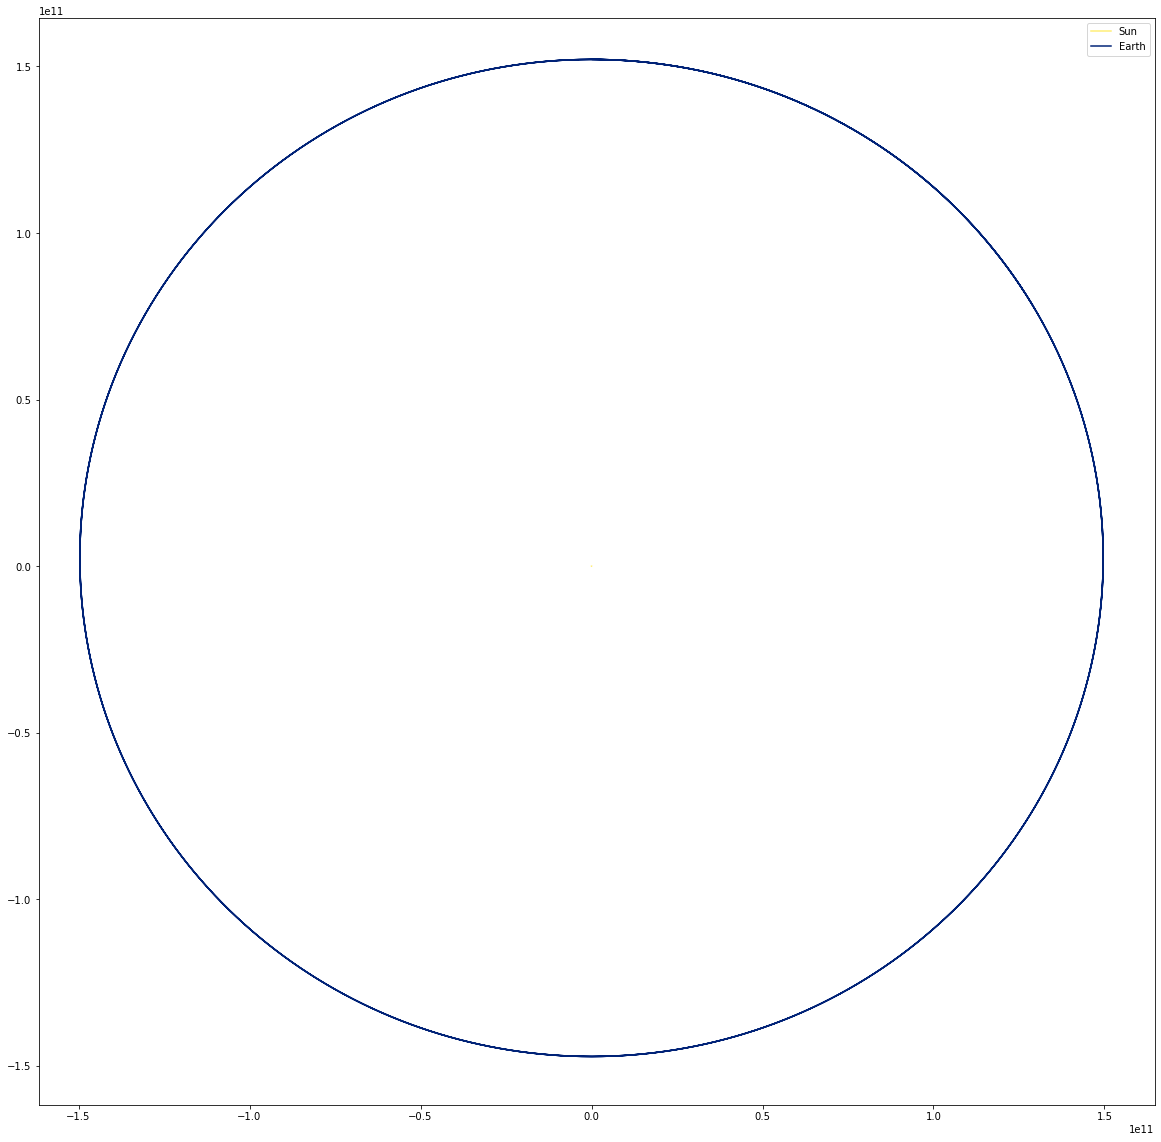

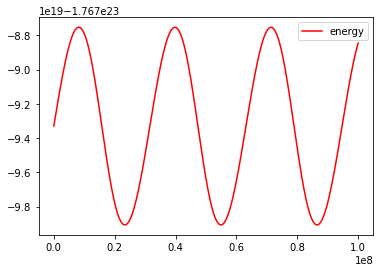

In [45]:
interval = 10000;
steps = 10000
p_axes, mmin, mmax = verlet(particles, interval, steps)

#verlet(particles, 0.1, 60000)

### Animate


In [46]:
def positionGenerator():
    xpositions = []
    ypositions = []
    i=0
    skip = int(steps / 500)
    while i < 500:
        xpositions = []
        ypositions = []
        if (i/5)%10 == 0:
            print(i/500*100 , "%", i*skip)
        for p in p_axes:
            xpositions.append(p[0][int(i * skip)])
            ypositions.append(p[1][int(i * skip)])
        i+= 1
        yield np.c_[xpositions, ypositions]
    return

0.0 % 0
10.0 % 1000
20.0 % 2000
30.0 % 3000
40.0 % 4000
50.0 % 5000
60.0 % 6000
70.0 % 7000
80.0 % 8000
90.0 % 9000


StopIteration: 

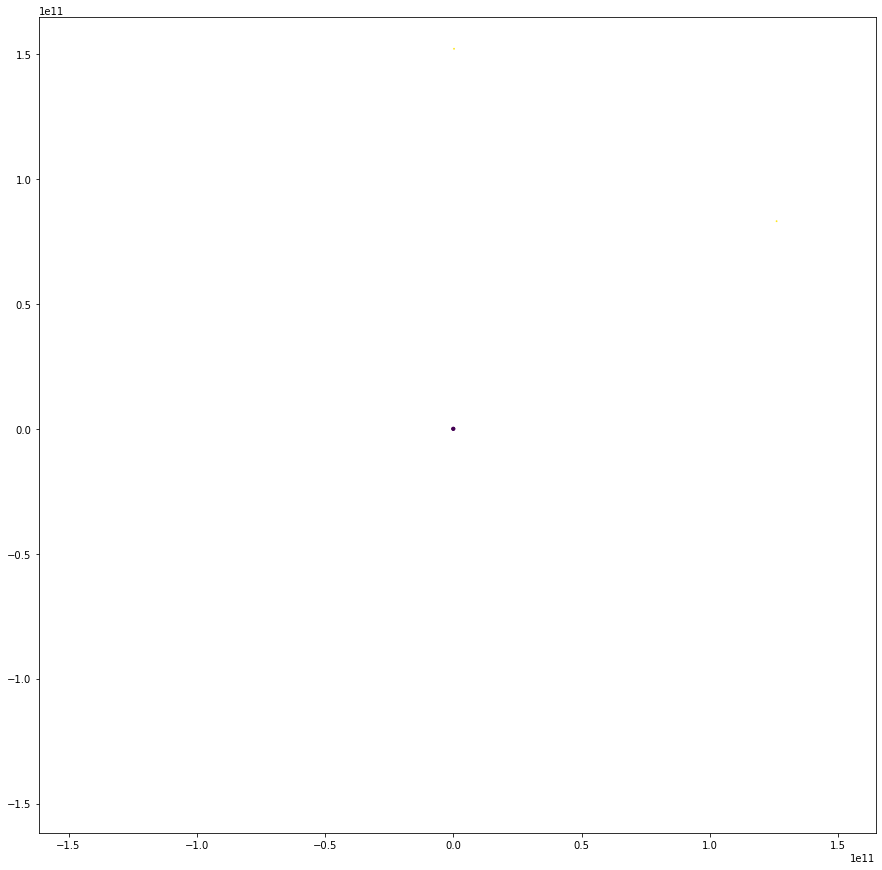

In [47]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = './ffmpeg.exe'




class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""

    def __init__(self, numpoints=steps):
        self.numpoints = numpoints
        self.particles = particles
        self.stream = positionGenerator()

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        self.fig.set_figheight(15)
        self.fig.set_figwidth(15)
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=25, frames=500,
                                           init_func=self.setup_plot, blit=True)
        self.ani.save('scatter.mp4', writer='ffmpeg', fps=40, dpi=100, metadata={'title':'test'})
        #video = self.ani.to_html5_video()
        #html = display.HTML(video)
        #display.display(html)
        plt.close()                   # avoid plotting a spare static plot

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        
        x, y = next(self.stream).T
        self.scat = self.ax.scatter(x, y, s=s, c=c)
        self.ax.axis([mmin, mmax, mmin, mmax])
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.


        return self.scat,


    def update(self, i):
        """Update the scatter plot."""
        data = next(self.stream)
        # Set x and y data...
        self.scat.set_offsets(data[:, :2])
        # Set sizes...

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

a = AnimatedScatter()
plt.show()
